# 本文件说明
- 统计分析
> - 八分类模型数据：噪音与非噪音
> - 补录和预警数据

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['监管', '行业', '公司内部管理', '消费服务']
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_cor', 'sum']
    count_data_4['al_uncor'] = count_data_4['sum'] - count_data_4['al_cor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

# 参数设置

In [9]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-10-19
昨天是： 2018-10-18
统计的是昨天的数据，即 2018-10-18 的数据
start_day： 2018-09-18
end_day： 2018-10-19


In [10]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [11]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

# 保险业--旧

## 特殊时间点

In [12]:
engine = specific_func.get_engine('circ')

In [13]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [14]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-10-19,补录,1
1,2018-10-19,监管,1030
2,2018-10-19,行业,558
3,2018-10-19,产品销售,273
4,2018-10-19,资本市场,1088


In [15]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-10-19,噪音,11211
1,2018-10-18,噪音,81041
2,2018-10-17,噪音,86267
3,2018-10-16,噪音,99378
4,2018-10-15,噪音,98852


### 补录数据

,publishtime,补录
0,2018-10-19,1
8,2018-10-18,20
16,2018-10-17,9
24,2018-10-16,10
32,2018-10-15,5


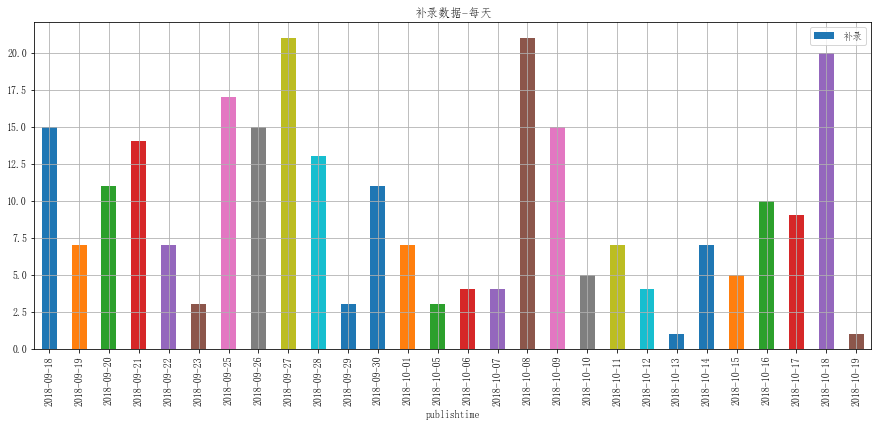

In [16]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [17]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-10-19   273.000  470.000  354.000 11211.000  160.000 1030.000  558.000   
2018-10-18  1567.000 3510.000 1937.000 81041.000 1487.000 2473.000 2765.000   
2018-10-17  1675.000 2268.000 1990.000 86267.000 2074.000 2345.000 2312.000   
2018-10-16  1615.000 2323.000 1530.000 99378.000 1930.000 2379.000 2486.000   
2018-10-15  1335.000 1977.000 1409.000 98852.000 1404.000 3260.000 1797.000   

                                     总量       非噪音 非噪音-比例 噪音-比例  
classify        补录      资本市场                                    
publishtime                                                     
2018-10-19   1.000  1088.000  15145.000  3934.000  0.260 0.740  
2018-10-18  20.000  4007.000  98807.000 17766.000  0.180 0.820  
2018-10-17   9.000  9444.000 108384.000 22117.000  0.204 0.796  
2018-10-16  10.000 12784.000 124435.000 25057.000  0.201 0.799  
2018-10-15   5.000 10473.000 120512.000 21660.000  0.180 0.820

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-10-19   273.000  470.000  354.000 11211.000  160.000 1030.000  558.000   
2018-10-18  1567.000 3510.000 1937.000 81041.000 1487.000 2473.000 2765.000   
2018-10-17  1675.000 2268.000 1990.000 86267.000 2074.000 2345.000 2312.000   
2018-10-16  1615.000 2323.000 1530.000 99378.000 1930.000 2379.000 2486.000   
2018-10-15  1335.000 1977.000 1409.000 98852.000 1404.000 3260.000 1797.000   

                                     总量  rate                                  \
classify        补录      资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                     
2018-10-19   1.000  1088.000  15145.000 0.018  0.031  0.023 0.740 0.011 0.068   
2018-10-18  20.000  4007.000  98807.000 0.016  0.036  0.020 0.820 0.015 0.025   
2018-10-17   9.000  9444.000 108384.000 0.015  0.021  0.018 0.796 0.019 0.022   
2018-10-16  10.000 12784.000 124435.000 0.013  0.019  0.012 0.799 0.016 0.019   
2018-10-15   5.000 10473.000 120512.000 0.011  0.016  0.012 0.820 0.012 0.027   

                               
classify       行业    补录  资本市场  
publishtime                    
2018-10-19  0.037 0.000 0.072  
2018-10-18  0.028 0.000 0.041  
2018-10-17  0.021 0.000 0.087  
2018-10-16  0.020 0.000 0.103  
2018-10-15  0.015 0.000 0.087

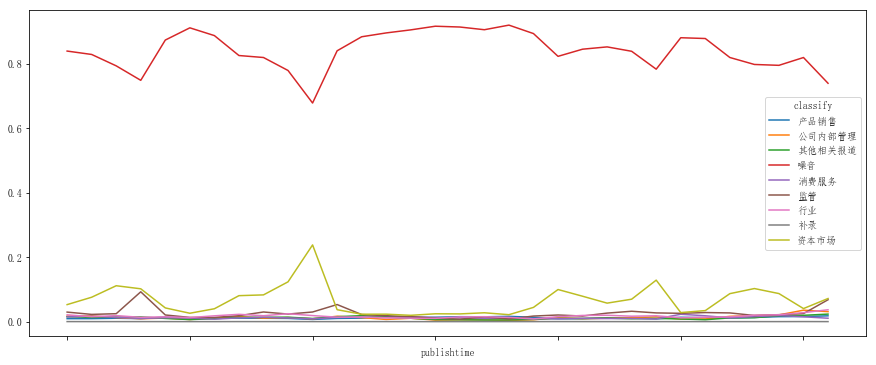

In [18]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

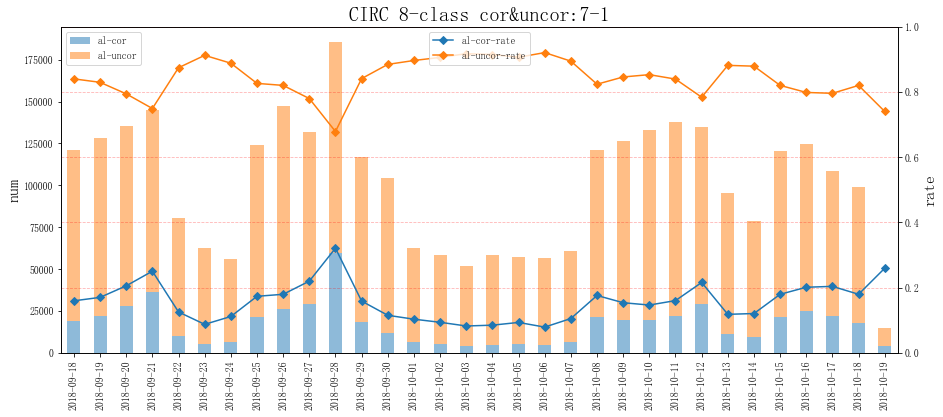

   publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-19  15145.000  3934.000 11211.000        0.260          0.740
30  2018-10-18  98807.000 17766.000 81041.000        0.180          0.820
29  2018-10-17 108384.000 22117.000 86267.000        0.204          0.796
28  2018-10-16 124435.000 25057.000 99378.000        0.201          0.799
27  2018-10-15 120512.000 21660.000 98852.000        0.180          0.820


In [19]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

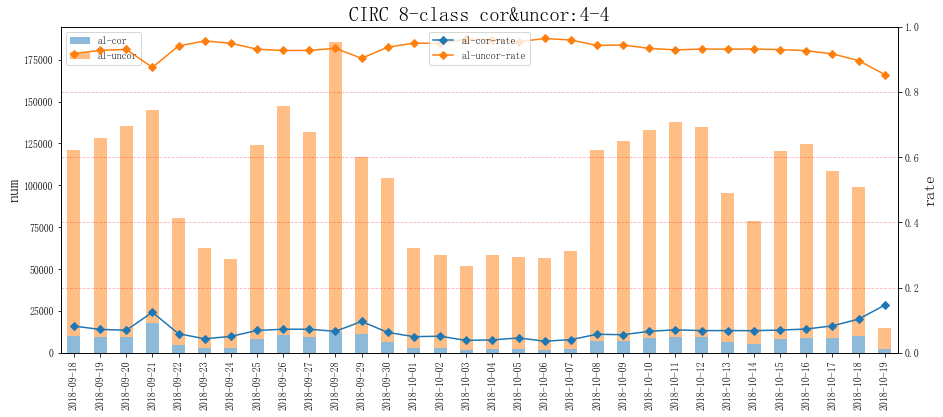

   publishtime    al_cor        sum   al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-19  2218.000  15145.000  12927.000        0.146          0.854
30  2018-10-18 10235.000  98807.000  88572.000        0.104          0.896
29  2018-10-17  8999.000 108384.000  99385.000        0.083          0.917
28  2018-10-16  9118.000 124435.000 115317.000        0.073          0.927
27  2018-10-15  8438.000 120512.000 112074.000        0.070          0.930


In [20]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [21]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-10-19,-1,668
1,2018-10-19,0,3731
2,2018-10-18,-1,3474
3,2018-10-18,0,14334
4,2018-10-17,-1,1930


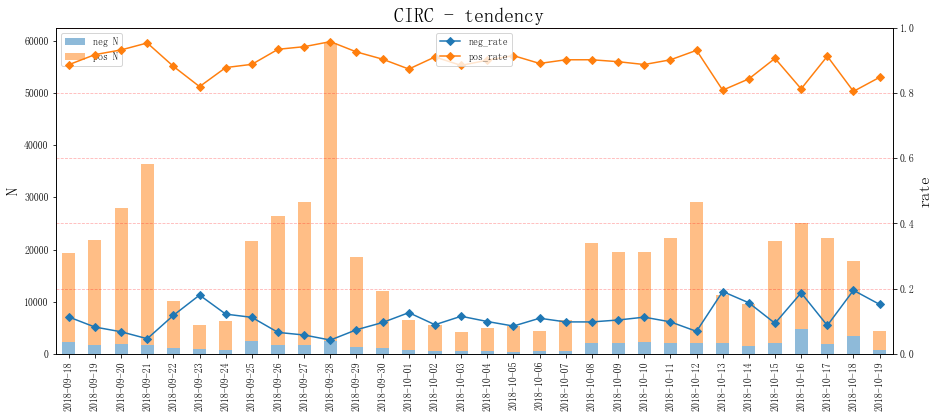

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-10-19   668   3731   4399     0.152     0.848
30  2018-10-18  3474  14334  17808     0.195     0.805
29  2018-10-17  1930  20194  22124     0.087     0.913
28  2018-10-16  4693  20365  25058     0.187     0.813
27  2018-10-15  2034  19626  21660     0.094     0.906


In [22]:
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [23]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [24]:
add_start_day = '2018-10-13'
add_end_day = '2018-10-19'

In [25]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(53, 7)


In [26]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(123, 7)


In [27]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (176, 7)
去重后 (126, 7)


In [28]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,5614785,行业,,1,1
1,11318838,噪音,,0,0
2,11325122,消费服务,,1,1
3,11331916,噪音,,0,0
4,11331917,资本市场,,0,1


In [29]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [30]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [31]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,新闻客户端,纸媒,视频,总量
保监会：2018-10-13 到 2018-10-19,,,,,,
补录,15.000,34.000,1.000,2.000,1.000,53.000
预警数量,15.000,78.000,1.000,28.000,1.000,123.000
补录且预警,15.000,31.000,1.000,2.000,1.000,50.000
补录&过算法(7类),12.000,26.000,1.000,2.000,NaN,41.000
补录且预警&过算法(7类),12.000,24.000,1.000,2.000,NaN,39.000
补录且预警 / 预警-比例,100%,40%,100%,7%,100%,41%
补录且预警 / 补录-比例,100%,91%,100%,100%,100%,94%
补录&过算法(7类) / 补录-比例,80%,76%,100%,100%,nan%,77%
补录且预警&过算法(7类) / 补录且预警-比例,80%,77%,100%,100%,nan%,78%


### 导出一段时间补录数据用于训练

In [32]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [33]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [34]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧

## 特殊时间点

In [35]:
engine = specific_func.get_engine('cbrc')

In [36]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [37]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-10-19,监管,3347
1,2018-10-19,行业,2685
2,2018-10-19,产品销售,293
3,2018-10-19,资本市场,6186
4,2018-10-19,公司内部管理,682


### class

In [38]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-10-19    293    682    846   14085   1804   3347   2685   6186   29928   
2018-10-18   2742   4694   5794   85389  10629  13767  18338  29420  170773   
2018-10-17   3932   3964   6048   94529  14052  14913  16572  25304  179314   
2018-10-16   4395   3856   6267  113752  26836  17757  15749  31174  219786   
2018-10-15   4379   3717   4893  102388  19153  18263  16328  30575  199696   

                非噪音 非噪音-比例 噪音-比例  
classify                          
publishtime                       
2018-10-19    15843  0.529 0.471  
2018-10-18    85384  0.500 0.500  
2018-10-17    84785  0.473 0.527  
2018-10-16   106034  0.482 0.518  
2018-10-15    97308  0.487 0.513

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-10-19    293    682    846   14085   1804   3347   2685   6186   29928   
2018-10-18   2742   4694   5794   85389  10629  13767  18338  29420  170773   
2018-10-17   3932   3964   6048   94529  14052  14913  16572  25304  179314   
2018-10-16   4395   3856   6267  113752  26836  17757  15749  31174  219786   
2018-10-15   4379   3717   4893  102388  19153  18263  16328  30575  199696   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-10-19  0.010  0.023  0.028 0.471 0.060 0.112 0.090 0.207  
2018-10-18  0.016  0.027  0.034 0.500 0.062 0.081 0.107 0.172  
2018-10-17  0.022  0.022  0.034 0.527 0.078 0.083 0.092 0.141  
2018-10-16  0.020  0.018  0.029 0.518 0.122 0.081 0.072 0.142  
2018-10-15  0.022  0.019  0.025 0.513 0.096 0.091 0.082 0.153

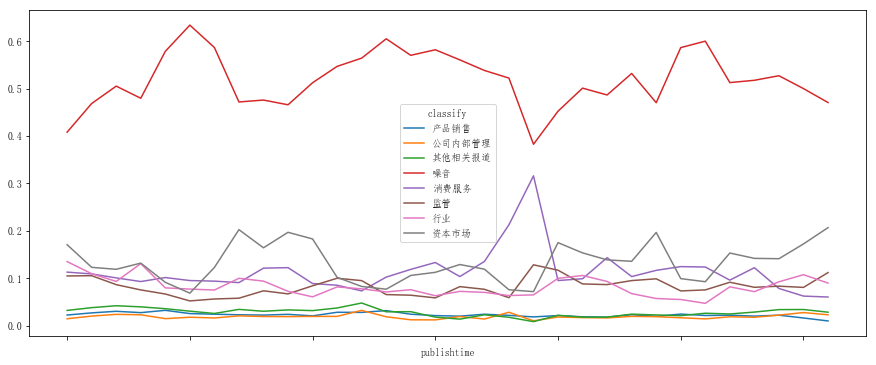

In [39]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

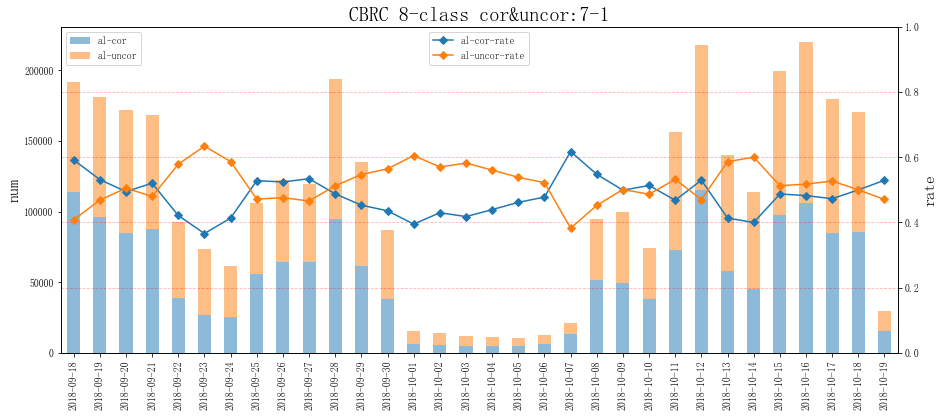

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-19   29928   15843     14085        0.529          0.471
30  2018-10-18  170773   85384     85389        0.500          0.500
29  2018-10-17  179314   84785     94529        0.473          0.527
28  2018-10-16  219786  106034    113752        0.482          0.518
27  2018-10-15  199696   97308    102388        0.487          0.513


In [40]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

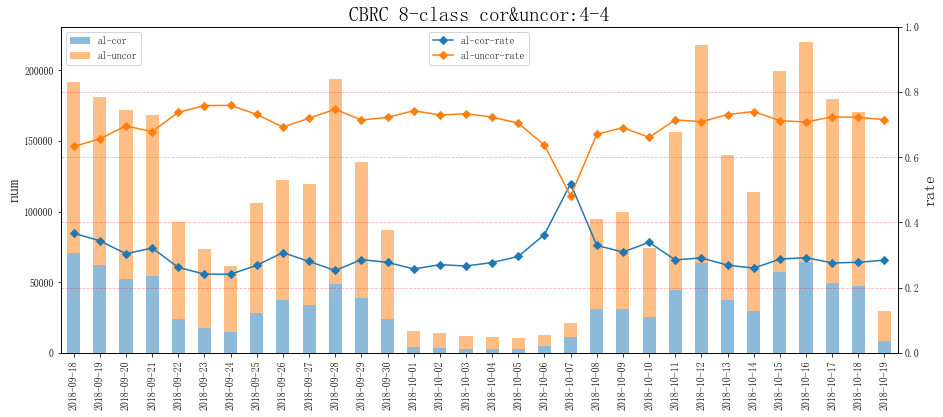

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-19    8518   29928     21410        0.285          0.715
30  2018-10-18   47428  170773    123345        0.278          0.722
29  2018-10-17   49501  179314    129813        0.276          0.724
28  2018-10-16   64198  219786    155588        0.292          0.708
27  2018-10-15   57461  199696    142235        0.288          0.712


In [41]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [42]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-10-19,-1,402
1,2018-10-19,0,8597
3,2018-10-18,-1,3175
4,2018-10-18,0,45755
6,2018-10-17,-1,2919


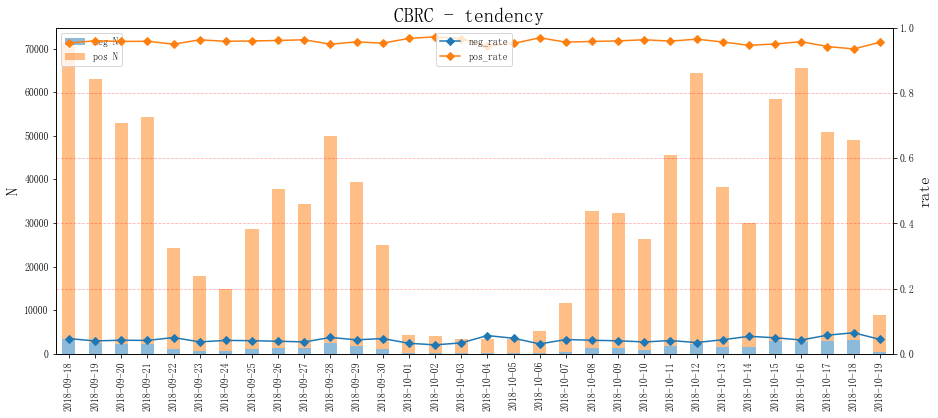

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-10-19   402   8597   8999     0.045     0.955
30  2018-10-18  3175  45755  48930     0.065     0.935
29  2018-10-17  2919  47846  50765     0.058     0.942
28  2018-10-16  2792  62640  65432     0.043     0.957
27  2018-10-15  2902  55568  58470     0.050     0.950


In [43]:
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [44]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-10-19,1,2
1,2018-10-18,1,25
2,2018-10-17,1,33
3,2018-10-16,1,37
4,2018-10-15,1,34


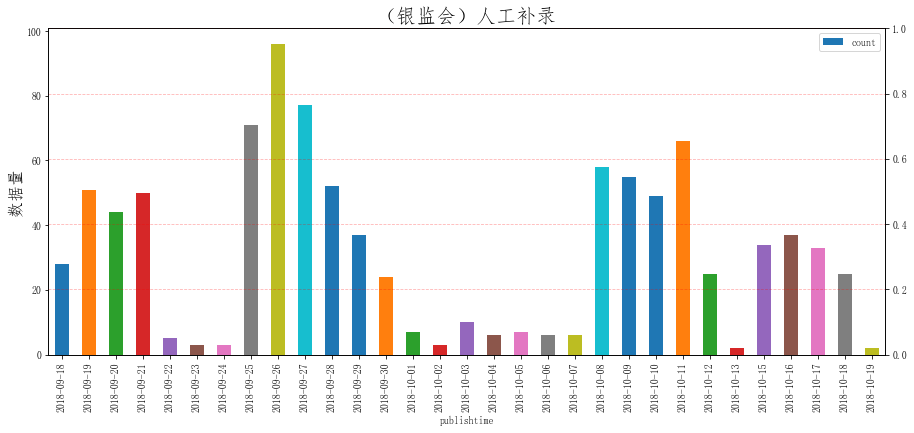

,publishtime,gather_type,count
0,2018-10-19,1,2
1,2018-10-18,1,25
2,2018-10-17,1,33
3,2018-10-16,1,37
4,2018-10-15,1,34


In [45]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [46]:
add_start_day = '2018-10-13'
add_end_day = '2018-10-19'

In [47]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(133, 7)


In [48]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(286, 7)


In [49]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (419, 7)
去重后 (298, 7)


In [50]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
人工修改         外媒        预警           1
             微信        预警           4
             新闻        预警          92
             新闻客户端     预警           4
             纸媒        预警          57
             论坛        预警           7
人工补录         微信        不预警          1
                       预警           4
             微博        不预警          1
                       预警          92
             新闻        不预警          8
                       预警          19
             新闻客户端     不预警          1
                       预警           1
             纸媒        不预警          1
                       预警           5
Name: id, dtype: int64

In [51]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,261642105,监管,,1,1
1,261681492,资本市场,,0,1
2,262564267,监管,,1,1
3,262566178,噪音,,0,0
4,262613942,公司内部管理,,0,1


In [52]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [53]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [54]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,新闻客户端,纸媒,总量
保监会：2018-10-13 到 2018-10-19,,,,,,
补录,5.000,93.000,27.000,2.000,6.000,133.000
预警数量,8.000,92.000,111.000,5.000,62.000,278.000
补录且预警,4.000,92.000,19.000,1.000,5.000,121.000
补录&过算法(4类),4.000,87.000,13.000,2.000,4.000,110.000
补录且预警&过算法(4类),3.000,86.000,6.000,1.000,3.000,99.000
补录&过算法(7类),5.000,92.000,25.000,2.000,5.000,129.000
补录且预警&过算法(7类),4.000,91.000,17.000,1.000,4.000,117.000
补录且预警 / 预警-比例,50%,100%,17%,20%,8%,44%
补录且预警 / 补录-比例,80%,99%,70%,50%,83%,91%


### 导出一段时间补录数据用于训练

In [55]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [56]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [57]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 银保监会--新

## 特殊时间点

In [58]:
engine = specific_func.get_engine('cbirc')

In [59]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [60]:
start_day = today - datetime.timedelta(days=8) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

start_day： 2018-10-11
end_day： 2018-10-18


## 八分类

In [61]:
sql_cbirc = '''
SELECT 
    DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
    t2.type,
    t1.traffic_id AS classify,
    COUNT(t1.id) AS count
FROM
    cbrc_circ.db_classify_traffic_docinfo t1
        LEFT JOIN
    cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
        LEFT JOIN
    cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
WHERE
    date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
        AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id
'''.format(start_day, end_day)

cbirc_count = pd.read_sql(sql_cbirc, engine)
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[x])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
cbirc_count.head()

(256, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 4 columns):
publishtime    256 non-null object
type           256 non-null int64
classify       256 non-null object
count          256 non-null int64
dtypes: int64(2), object(2)
memory usage: 46.3 KB
None


,publishtime,type,classify,count
0,2018-10-11,1,监管,5912
1,2018-10-11,1,行业,3789
2,2018-10-11,1,产品销售,3803
3,2018-10-11,1,资本市场,8824
4,2018-10-11,1,公司内部管理,2065


In [62]:
print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

1297401


sum                                
              count                                
type              1       2      3       4      All
publishtime                                        
2018-10-11    81477   79001   5033   17612   183123
2018-10-12    77934   88527   4170   15441   186072
2018-10-13    50634   60921   2407   10311   124273
2018-10-14    41663   50056   2082    9963   103764
2018-10-15    83961   79025   4453   23009   190448
2018-10-16    96080   83760   5523   16745   202108
2018-10-17    74189   73333   3269   11568   162359
2018-10-18    66352   61565   3966   13371   145254
All          572290  576188  30903  118020  1297401

In [63]:
# sql_1 = '''
# select 
#     t1.urlhash, t1.type, date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime
# from 
#     db_docinfo_trade t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_1 = pd.read_sql(sql_1, engine)
# print(cbirc_count_1.shape)
# print(cbirc_count_1.info(memory_usage = 'deep'))
# cbirc_count_1.head()

In [64]:
# sql_2 = '''
# select 
#     t1.urlhash, t1.traffic_id as classify
# from 
#     db_classify_traffic_docinfo t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_2 = pd.read_sql(sql_2, engine)
# print(cbirc_count_2.shape)
# print(cbirc_count_2.info(memory_usage = 'deep'))
# cbirc_count_2.head()

In [65]:
# cbirc_merge = pd.merge(cbirc_count_1, cbirc_count_2, on = 'urlhash', how = 'inner')
# print(cbirc_merge.shape)
# cbirc_merge.head()

In [66]:
# cbirc_merge.pivot_table(index = ['publishtime'], columns = ['type'], 
#                         aggfunc = [len], values = ['urlhash'], 
#                         fill_value = 0, margins = True)

In [67]:
# cbirc_count = cbirc_merge.groupby(['type', 'publishtime', 'classify'])['urlhash'].count().reset_index()
# cbirc_count.columns = ['type', 'publishtime', 'classify', 'count']
# cbirc_count.sort_values(by = 'publishtime', ascending = False).head()

### 银监会

In [68]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2018-10-18   1854   3070   3566  40969  1459  3271  6371   5792  66352  25383   
2018-10-17   3671   2671   3791  45014  2336  2797  4349   9560  74189  29175   
2018-10-16   9971   2682   3933  54324  7646  4736  3930   8858  96080  41756   
2018-10-15   6067   2324   3039  46245  3591  5157  3603  13935  83961  37716   
2018-10-14   2086    935   1529  28884  1738  1998  1499   2994  41663  12779   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-18   0.383 0.617  
2018-10-17   0.393 0.607  
2018-10-16   0.435 0.565  
2018-10-15   0.449 0.551  
2018-10-14   0.307 0.693

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2018-10-18   1854   3070   3566  40969  1459  3271  6371   5792  66352 0.028   
2018-10-17   3671   2671   3791  45014  2336  2797  4349   9560  74189 0.049   
2018-10-16   9971   2682   3933  54324  7646  4736  3930   8858  96080 0.104   
2018-10-15   6067   2324   3039  46245  3591  5157  3603  13935  83961 0.072   
2018-10-14   2086    935   1529  28884  1738  1998  1499   2994  41663 0.050   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-18   0.046  0.054 0.617 0.022 0.049 0.096 0.087  
2018-10-17   0.036  0.051 0.607 0.031 0.038 0.059 0.129  
2018-10-16   0.028  0.041 0.565 0.080 0.049 0.041 0.092  
2018-10-15   0.028  0.036 0.551 0.043 0.061 0.043 0.166  
2018-10-14   0.022  0.037 0.693 0.042 0.048 0.036 0.072

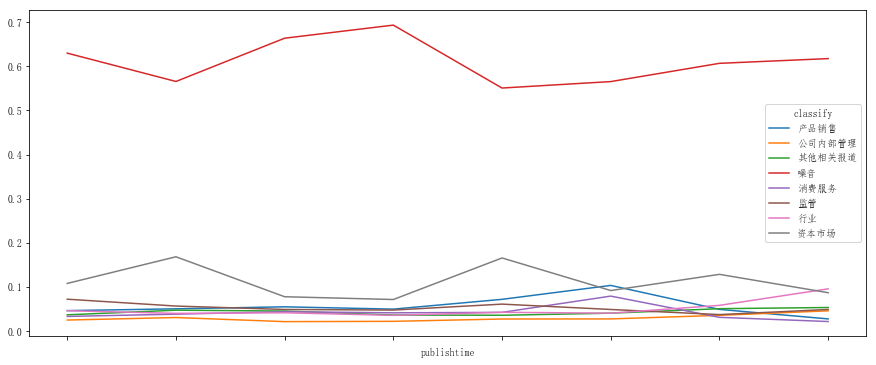

In [69]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

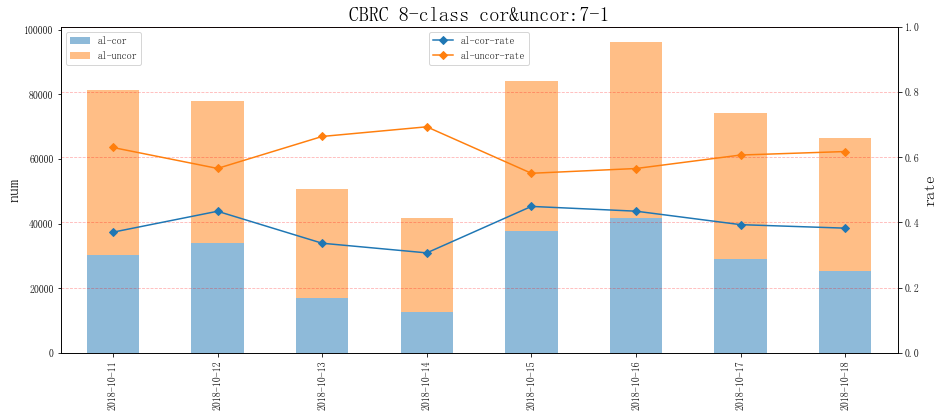

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18  66352   25383     40969        0.383          0.617
6  2018-10-17  74189   29175     45014        0.393          0.607
5  2018-10-16  96080   41756     54324        0.435          0.565
4  2018-10-15  83961   37716     46245        0.449          0.551
3  2018-10-14  41663   12779     28884        0.307          0.693


In [70]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

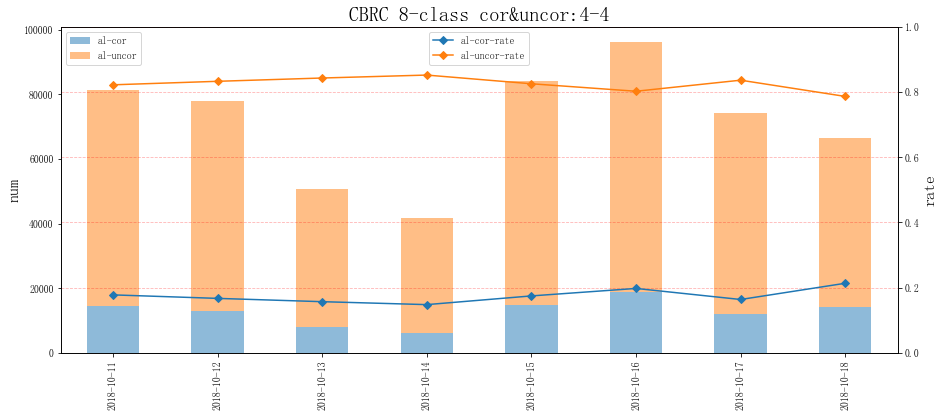

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18   14171  66352     52181        0.214          0.786
6  2018-10-17   12153  74189     62036        0.164          0.836
5  2018-10-16   18994  96080     77086        0.198          0.802
4  2018-10-15   14675  83961     69286        0.175          0.825
3  2018-10-14    6170  41663     35493        0.148          0.852


In [71]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

In [72]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2018-10-18   1854   3070   3566  40969  1459  3271  6371   5792  66352  25383   
2018-10-17   3671   2671   3791  45014  2336  2797  4349   9560  74189  29175   
2018-10-16   9971   2682   3933  54324  7646  4736  3930   8858  96080  41756   
2018-10-15   6067   2324   3039  46245  3591  5157  3603  13935  83961  37716   
2018-10-14   2086    935   1529  28884  1738  1998  1499   2994  41663  12779   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-18   0.383 0.617  
2018-10-17   0.393 0.607  
2018-10-16   0.435 0.565  
2018-10-15   0.449 0.551  
2018-10-14   0.307 0.693

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2018-10-18   1854   3070   3566  40969  1459  3271  6371   5792  66352 0.028   
2018-10-17   3671   2671   3791  45014  2336  2797  4349   9560  74189 0.049   
2018-10-16   9971   2682   3933  54324  7646  4736  3930   8858  96080 0.104   
2018-10-15   6067   2324   3039  46245  3591  5157  3603  13935  83961 0.072   
2018-10-14   2086    935   1529  28884  1738  1998  1499   2994  41663 0.050   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-18   0.046  0.054 0.617 0.022 0.049 0.096 0.087  
2018-10-17   0.036  0.051 0.607 0.031 0.038 0.059 0.129  
2018-10-16   0.028  0.041 0.565 0.080 0.049 0.041 0.092  
2018-10-15   0.028  0.036 0.551 0.043 0.061 0.043 0.166  
2018-10-14   0.022  0.037 0.693 0.042 0.048 0.036 0.072

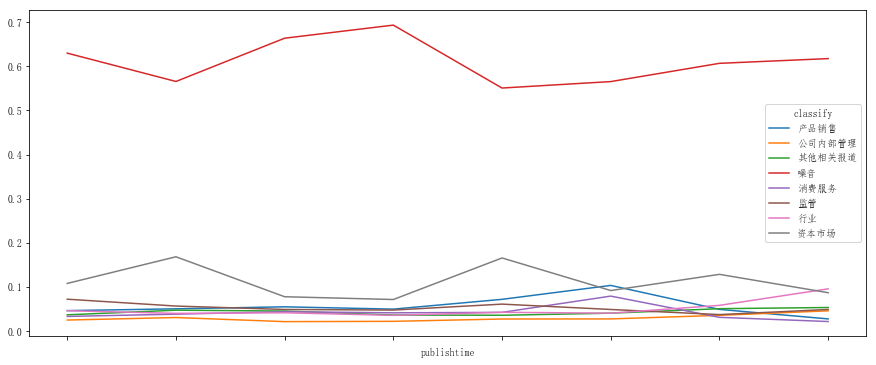

In [73]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

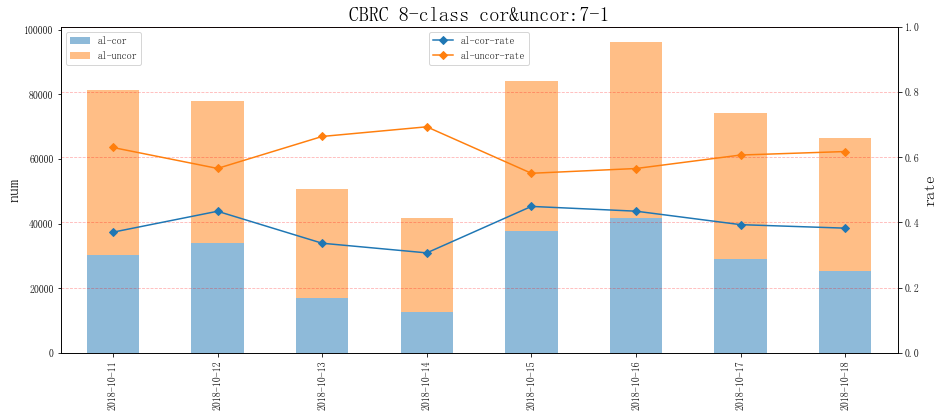

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18  66352   25383     40969        0.383          0.617
6  2018-10-17  74189   29175     45014        0.393          0.607
5  2018-10-16  96080   41756     54324        0.435          0.565
4  2018-10-15  83961   37716     46245        0.449          0.551
3  2018-10-14  41663   12779     28884        0.307          0.693


In [74]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

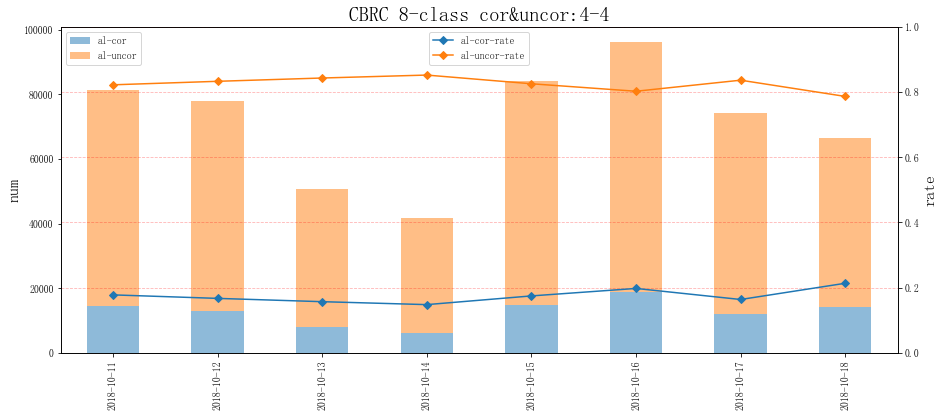

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18   14171  66352     52181        0.214          0.786
6  2018-10-17   12153  74189     62036        0.164          0.836
5  2018-10-16   18994  96080     77086        0.198          0.802
4  2018-10-15   14675  83961     69286        0.175          0.825
3  2018-10-14    6170  41663     35493        0.148          0.852


In [75]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [76]:
class_count = cbirc_count[cbirc_count['type'] == 2].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2018-10-18    853   1220    654  48510  1219  3345  3355   2409  61565  13055   
2018-10-17    880    557    684  56472  1461  2540  3003   7736  73333  16861   
2018-10-16    915    767    550  62449  1378  3171  2785  11745  83760  21311   
2018-10-15    751    688    486  60994  1158  4147  3760   7041  79025  18031   
2018-10-14    621    234    142  42954  1080  1957  1331   1737  50056   7102   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-18   0.212 0.788  
2018-10-17   0.230 0.770  
2018-10-16   0.254 0.746  
2018-10-15   0.228 0.772  
2018-10-14   0.142 0.858

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2018-10-18    853   1220    654  48510  1219  3345  3355   2409  61565 0.014   
2018-10-17    880    557    684  56472  1461  2540  3003   7736  73333 0.012   
2018-10-16    915    767    550  62449  1378  3171  2785  11745  83760 0.011   
2018-10-15    751    688    486  60994  1158  4147  3760   7041  79025 0.010   
2018-10-14    621    234    142  42954  1080  1957  1331   1737  50056 0.012   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-18   0.020  0.011 0.788 0.020 0.054 0.054 0.039  
2018-10-17   0.008  0.009 0.770 0.020 0.035 0.041 0.105  
2018-10-16   0.009  0.007 0.746 0.016 0.038 0.033 0.140  
2018-10-15   0.009  0.006 0.772 0.015 0.052 0.048 0.089  
2018-10-14   0.005  0.003 0.858 0.022 0.039 0.027 0.035

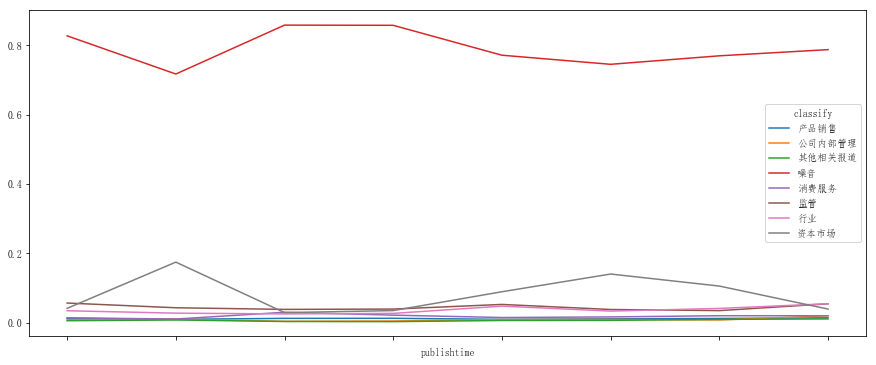

In [77]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

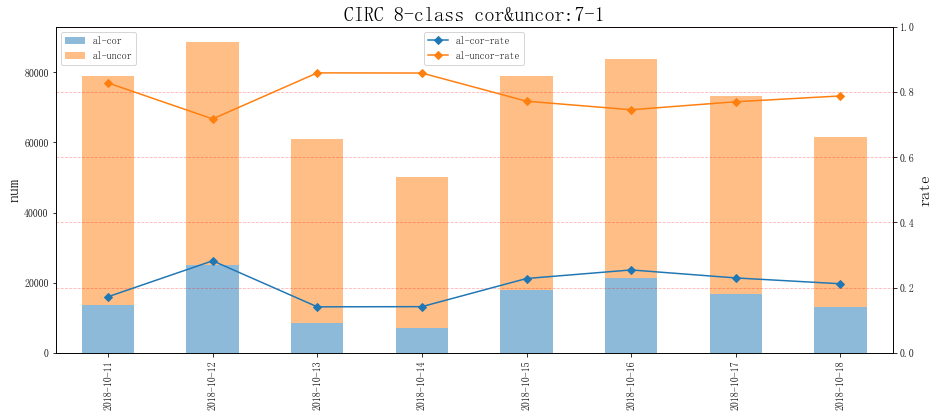

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18  61565   13055     48510        0.212          0.788
6  2018-10-17  73333   16861     56472        0.230          0.770
5  2018-10-16  83760   21311     62449        0.254          0.746
4  2018-10-15  79025   18031     60994        0.228          0.772
3  2018-10-14  50056    7102     42954        0.142          0.858


In [78]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

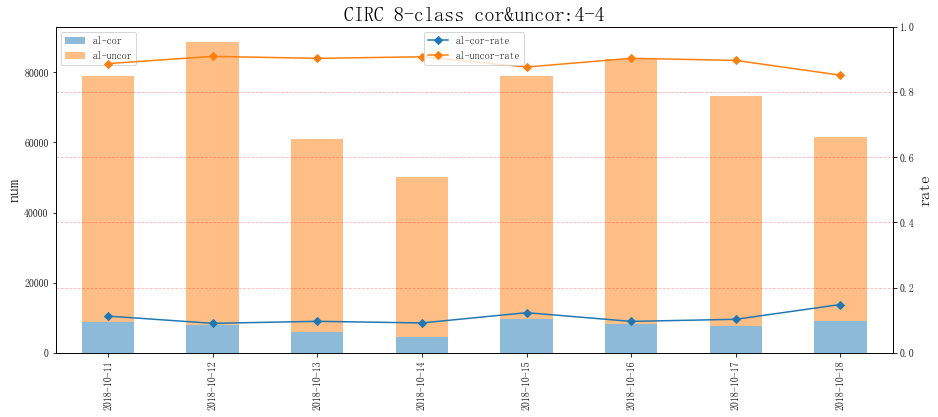

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18    9139  61565     52426        0.148          0.852
6  2018-10-17    7561  73333     65772        0.103          0.897
5  2018-10-16    8101  83760     75659        0.097          0.903
4  2018-10-15    9753  79025     69272        0.123          0.877
3  2018-10-14    4602  50056     45454        0.092          0.908


In [79]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [80]:
class_count = cbirc_count[cbirc_count['type'] == 3].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                            总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场                      
publishtime                                                                    
2018-10-18     58     95     37  2785   79  111  405  396  3966  1181  0.298   
2018-10-17     68     90     32  2439   44  133  273  190  3269   830  0.254   
2018-10-16    101    102     25  3877   36  380  676  326  5523  1646  0.298   
2018-10-15     81    143     49  3173   23  195  526  263  4453  1280  0.287   
2018-10-14     39     88     47  1461   24   70  274   79  2082   621  0.298   

            噪音-比例  
classify           
publishtime        
2018-10-18  0.702  
2018-10-17  0.746  
2018-10-16  0.702  
2018-10-15  0.713  
2018-10-14  0.702

count                                            总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                    
2018-10-18     58     95     37  2785   79  111  405  396  3966 0.015  0.024   
2018-10-17     68     90     32  2439   44  133  273  190  3269 0.021  0.028   
2018-10-16    101    102     25  3877   36  380  676  326  5523 0.018  0.018   
2018-10-15     81    143     49  3173   23  195  526  263  4453 0.018  0.032   
2018-10-14     39     88     47  1461   24   70  274   79  2082 0.019  0.042   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-10-18   0.009 0.702 0.020 0.028 0.102 0.100  
2018-10-17   0.010 0.746 0.013 0.041 0.084 0.058  
2018-10-16   0.005 0.702 0.007 0.069 0.122 0.059  
2018-10-15   0.011 0.713 0.005 0.044 0.118 0.059  
2018-10-14   0.023 0.702 0.012 0.034 0.132 0.038

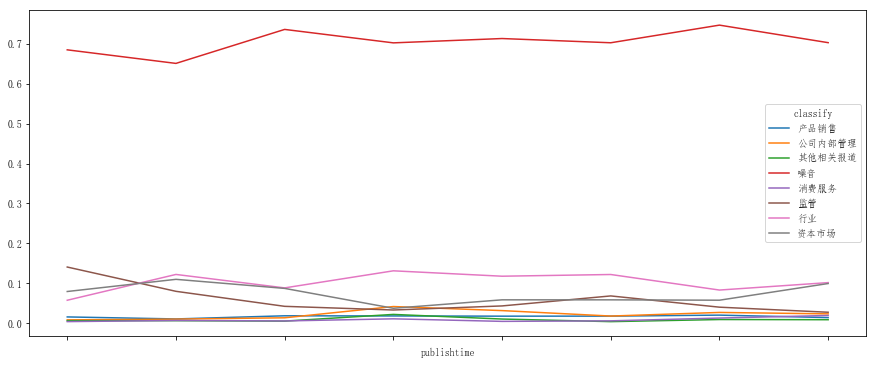

In [81]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

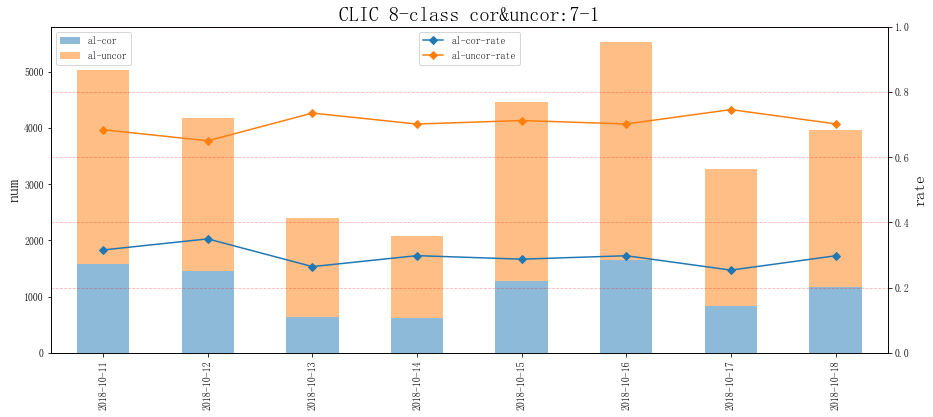

  publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18  3966    1181      2785        0.298          0.702
6  2018-10-17  3269     830      2439        0.254          0.746
5  2018-10-16  5523    1646      3877        0.298          0.702
4  2018-10-15  4453    1280      3173        0.287          0.713
3  2018-10-14  2082     621      1461        0.298          0.702


In [82]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

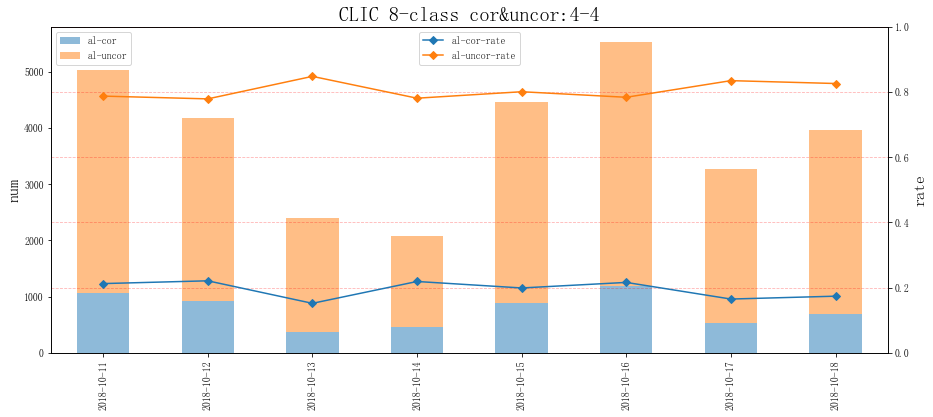

  publishtime  al_cor   sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18     690  3966      3276        0.174          0.826
6  2018-10-17     540  3269      2729        0.165          0.835
5  2018-10-16    1194  5523      4329        0.216          0.784
4  2018-10-15     887  4453      3566        0.199          0.801
3  2018-10-14     456  2082      1626        0.219          0.781


In [83]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [84]:
class_count = cbirc_count[cbirc_count['type'] == 4].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                 总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管    行业  资本市场                 
publishtime                                                                   
2018-10-18    253    500    514   8747  238  1201   778  1140  13371   4624   
2018-10-17    431    713    540   7071  304  1082   464   963  11568   4497   
2018-10-16    738    672    512   9533  359  1903   898  2130  16745   7212   
2018-10-15    797    881    468  10122  641  3980  1123  4997  23009  12887   
2018-10-14    763    737    368   5447  662   854   379   753   9963   4516   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-18   0.346 0.654  
2018-10-17   0.389 0.611  
2018-10-16   0.431 0.569  
2018-10-15   0.560 0.440  
2018-10-14   0.453 0.547

count                                                 总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                  
2018-10-18    253    500    514   8747  238  1201   778  1140  13371 0.019   
2018-10-17    431    713    540   7071  304  1082   464   963  11568 0.037   
2018-10-16    738    672    512   9533  359  1903   898  2130  16745 0.044   
2018-10-15    797    881    468  10122  641  3980  1123  4997  23009 0.035   
2018-10-14    763    737    368   5447  662   854   379   753   9963 0.077   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-18   0.037  0.038 0.654 0.018 0.090 0.058 0.085  
2018-10-17   0.062  0.047 0.611 0.026 0.094 0.040 0.083  
2018-10-16   0.040  0.031 0.569 0.021 0.114 0.054 0.127  
2018-10-15   0.038  0.020 0.440 0.028 0.173 0.049 0.217  
2018-10-14   0.074  0.037 0.547 0.066 0.086 0.038 0.076

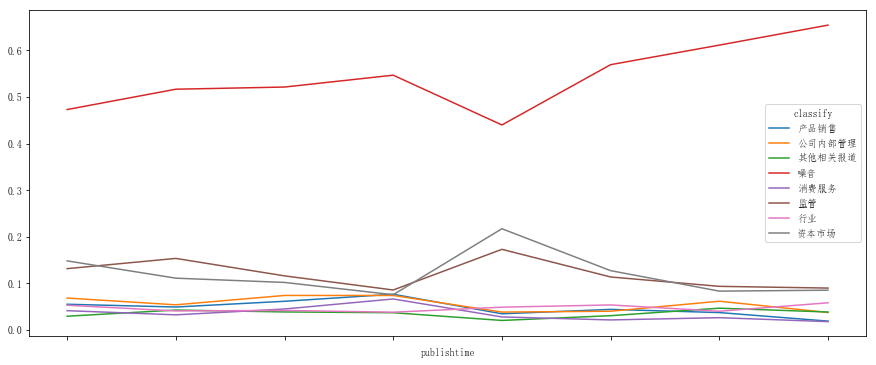

In [85]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

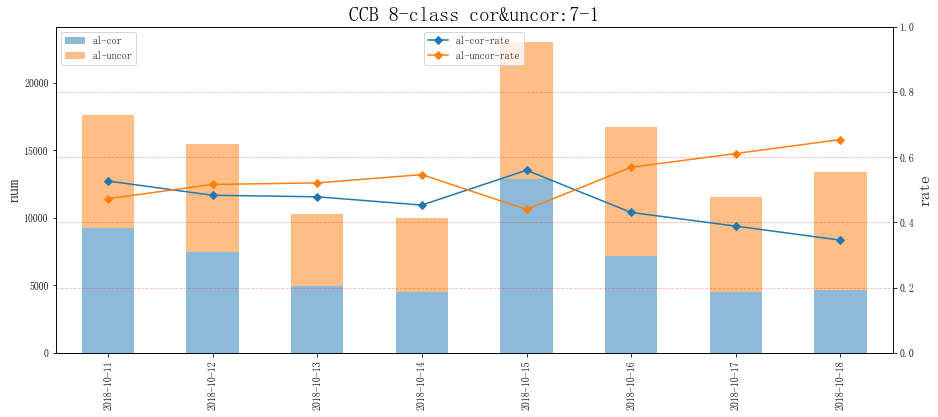

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18  13371    4624      8747        0.346          0.654
6  2018-10-17  11568    4497      7071        0.389          0.611
5  2018-10-16  16745    7212      9533        0.431          0.569
4  2018-10-15  23009   12887     10122        0.560          0.440
3  2018-10-14   9963    4516      5447        0.453          0.547


In [86]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

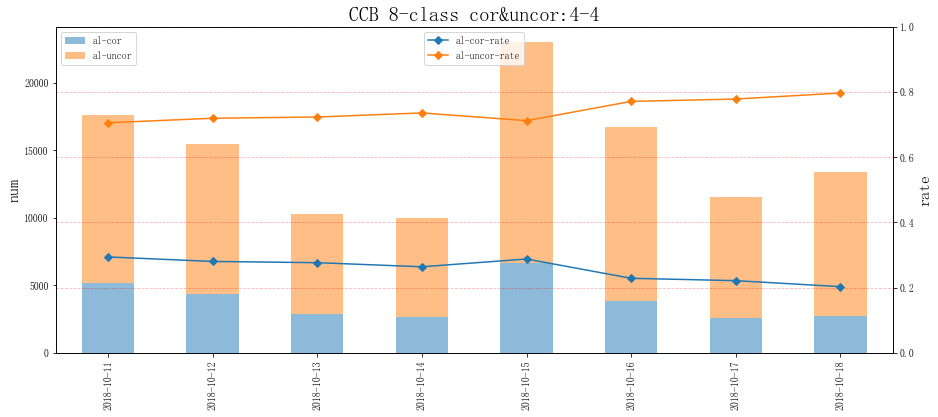

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-18    2717  13371     10654        0.203          0.797
6  2018-10-17    2563  11568      9005        0.222          0.778
5  2018-10-16    3832  16745     12913        0.229          0.771
4  2018-10-15    6625  23009     16384        0.288          0.712
3  2018-10-14    2632   9963      7331        0.264          0.736


In [87]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

## 倾向性

In [88]:
sql_tend = "select date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime, t1.type, \
                    t1.sen as tendency, count(t1.id) as cor_count \
                            from db_docinfo_trade t1, db_docinfo t2 \
                                where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.urlhash = t2.urlhash \
                                group by date_format(t2.publishtime,'%%Y-%%m-%%d'), t1.type, t1.sen \
                                order by date_format(t2.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
tend_count.head()

(64, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 4 columns):
publishtime    64 non-null object
type           64 non-null int64
tendency       64 non-null int64
cor_count      64 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.2 KB
None


,publishtime,type,tendency,cor_count
0,2018-10-18,1,-1,1701
1,2018-10-18,1,0,66779
2,2018-10-18,2,-1,1506
3,2018-10-18,2,0,61907
4,2018-10-18,3,-1,191


In [89]:
print(tend_count['cor_count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['cor_count'], 
                        fill_value = 0, margins = True)

1322209


sum                                
            cor_count                                
type                1       2      3       4      All
publishtime                                          
2018-10-11      80365   79536   6919   15075   181895
2018-10-12      77627   89517   6250   13389   186783
2018-10-13      50946   62117   3916    9288   126267
2018-10-14      42217   51680   3769    9204   106870
2018-10-15      84948   82212   6592   21212   194964
2018-10-16      97781   85603   7499   15323   206206
2018-10-17      76724   76028   5770   10546   169068
2018-10-18      68480   63413   5818   12445   150156
All            579088  590106  46533  106482  1322209

### 银监会

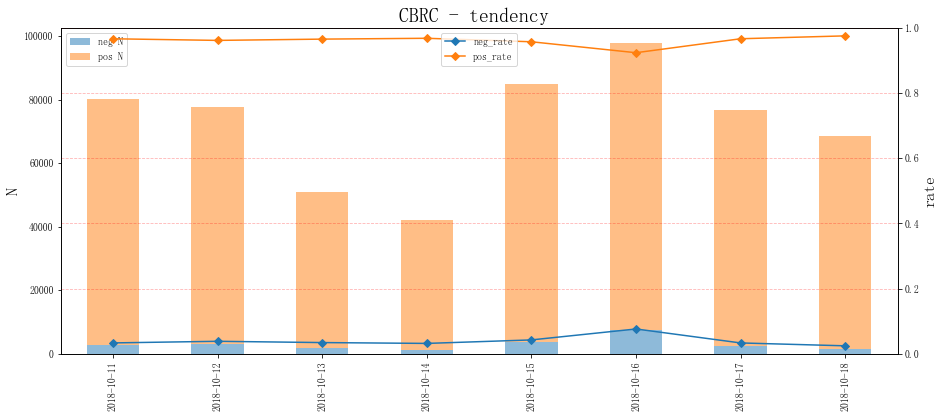

  publishtime   neg    pos    sum  neg_rate  pos_rate
7  2018-10-18  1701  66779  68480     0.025     0.975
6  2018-10-17  2583  74141  76724     0.034     0.966
5  2018-10-16  7480  90301  97781     0.076     0.924
4  2018-10-15  3648  81300  84948     0.043     0.957
3  2018-10-14  1361  40856  42217     0.032     0.968


In [90]:
plot_tend(tend_count[tend_count['type'] == 1].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency ")

### 保监会

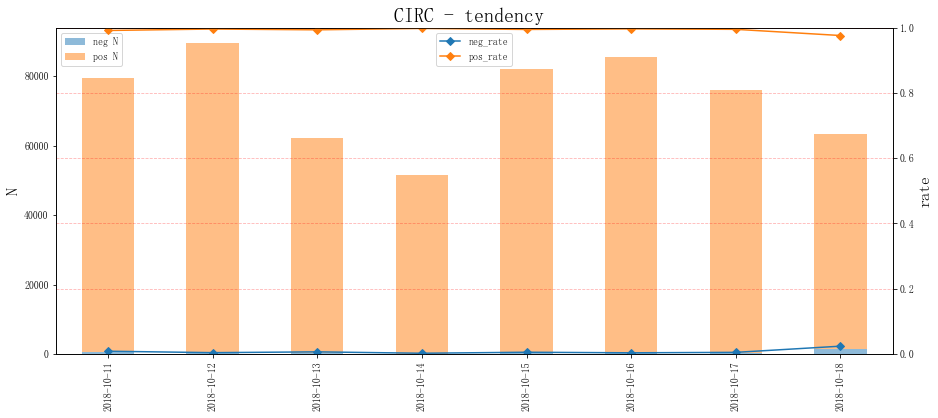

  publishtime   neg    pos    sum  neg_rate  pos_rate
7  2018-10-18  1506  61907  63413     0.024     0.976
6  2018-10-17   365  75663  76028     0.005     0.995
5  2018-10-16   294  85309  85603     0.003     0.997
4  2018-10-15   425  81787  82212     0.005     0.995
3  2018-10-14   107  51573  51680     0.002     0.998


In [91]:
plot_tend(tend_count[tend_count['type'] == 2].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency ")

### 中国人寿

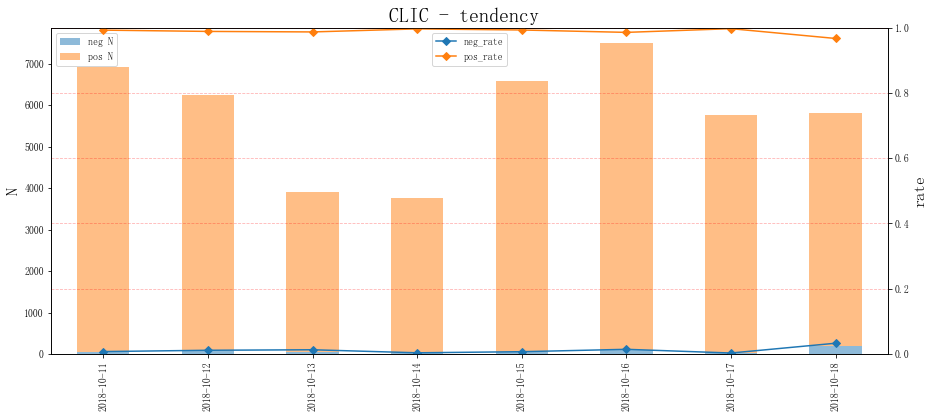

  publishtime  neg   pos   sum  neg_rate  pos_rate
7  2018-10-18  191  5627  5818     0.033     0.967
6  2018-10-17   16  5754  5770     0.003     0.997
5  2018-10-16  106  7393  7499     0.014     0.986
4  2018-10-15   45  6547  6592     0.007     0.993
3  2018-10-14   13  3756  3769     0.003     0.997


In [92]:
plot_tend(tend_count[tend_count['type'] == 3].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency ")

### 建行北分

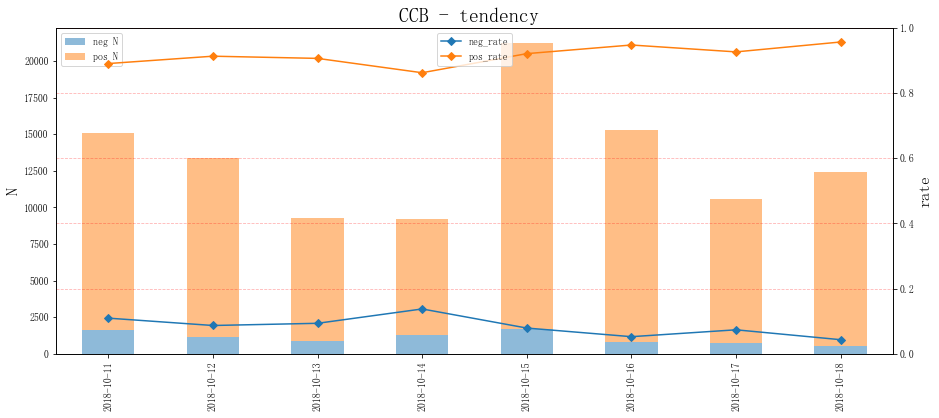

  publishtime   neg    pos    sum  neg_rate  pos_rate
7  2018-10-18   543  11902  12445     0.044     0.956
6  2018-10-17   780   9766  10546     0.074     0.926
5  2018-10-16   810  14513  15323     0.053     0.947
4  2018-10-15  1683  19529  21212     0.079     0.921
3  2018-10-14  1269   7935   9204     0.138     0.862


In [93]:
plot_tend(tend_count[tend_count['type'] == 4].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency ")

## 补录和预警